In [8]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [9]:
BASE_DIR = r"C:/Users/user/대학/VScode_File/GG-Image_Caption/GG_ImageCaptionGenerator/flickr8k"
WORKING_DIR = r"C:/Users/user/대학/VScode_File/GG-Image_Caption/Image_Caption_Working"

In [10]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/2408 [00:00<?, ?it/s]

In [13]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [14]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [15]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [17]:
len(mapping)

8091

In [18]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [19]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [20]:
# preprocess the text
clean(mapping)

In [21]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [22]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [23]:
len(all_captions)

40455

In [24]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [25]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [26]:
vocab_size

8485

In [27]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [28]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [29]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [30]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [31]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [32]:
print(features.keys())

dict_keys(['1015118661_980735411b', '1016887272_03199f49c4', '1022454332_6af2c1449a', '1042590306_95dea0916c', '1057089366_ca83da0877', '1075867198_27ca2e7efe', '1082252566_8c79beef93', '1089755335_0bfbfd30e6', '109671650_f7bbc297fa', '109823394_83fcb735e1', '1100214449_d10861e633', '111766423_4522d36e56', '1129704496_4a61441f2c', '1130401779_8c30182e3e', '113678030_87a6a6e42e', '1142847777_2a0c1c2551', '1164765687_7aca07bbe7', '1169307342_e7a4685a5c', '118309463_a532b75be9', '1187435567_18173c148b', '1191338263_a4fa073154', '1211015912_9f3ee3a995', '1234293791_6566284bcd', '1248953128_24c9f8d924', '1252396628_eb81d3905b', '125319704_49ead3463c', '1255504166_f2437febcb', '1263126002_881ebd7ac9', '1285067106_2adc307240', '1287064529_aa4e4f3c31', '128912885_8350d277a4', '1295671216_cde1b9c9d1', '1296770308_3db2022f5a', '1302657647_46b36c0d66', '1311132744_5ffd03f831', '1312954382_cf6d70d63a', '1329832826_432538d331', '1332492622_8c66992b62', '1335617803_4fbc03dab0', '133905560_9d012b47f3

In [26]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

# 필터링된 train 데이터셋 사용
filtered_train = [key for key in train if key in features]

for i in range(epochs):
    # create data generator
    generator = data_generator(filtered_train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


227/227 ━━━━━━━━━━━━━━━━━━━━ 115s 500ms/step - loss: 5.7549
227/227 ━━━━━━━━━━━━━━━━━━━━ 129s 571ms/step - loss: 3.6079
227/227 ━━━━━━━━━━━━━━━━━━━━ 134s 592ms/step - loss: 2.8388
227/227 ━━━━━━━━━━━━━━━━━━━━ 135s 595ms/step - loss: 2.3904
227/227 ━━━━━━━━━━━━━━━━━━━━ 136s 597ms/step - loss: 2.0729
227/227 ━━━━━━━━━━━━━━━━━━━━ 136s 600ms/step - loss: 1.8413
227/227 ━━━━━━━━━━━━━━━━━━━━ 138s 606ms/step - loss: 1.6668
227/227 ━━━━━━━━━━━━━━━━━━━━ 139s 611ms/step - loss: 1.4992
227/227 ━━━━━━━━━━━━━━━━━━━━ 141s 621ms/step - loss: 1.3801
227/227 ━━━━━━━━━━━━━━━━━━━━ 142s 625ms/step - loss: 1.2821
227/227 ━━━━━━━━━━━━━━━━━━━━ 143s 628ms/step - loss: 1.2090
227/227 ━━━━━━━━━━━━━━━━━━━━ 143s 630ms/step - loss: 1.1362
227/227 ━━━━━━━━━━━━━━━━━━━━ 144s 633ms/step - loss: 1.0493
227/227 ━━━━━━━━━━━━━━━━━━━━ 146s 642ms/step - loss: 0.9874
227/227 ━━━━━━━━━━━━━━━━━━━━ 147s 646ms/step - loss: 0.9295
227/227 ━━━━━━━━━━━━━━━━━━━━ 148s 652ms/step - loss: 0.8548
227/227 ━━━━━━━━━━━━━━━━━━━━ 149s 656ms/

In [33]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [34]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [37]:
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    
    # predict the caption for image
    if key in features:
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
    else:
        print(f"Warning: Key {key} not found in features")
        continue  # 이 경우 해당 이미지를 건너뜁니다.
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


 99%|█████████▉| 800/810 [19:42<00:12,  1.28s/it]

100%|██████████| 810/810 [19:53<00:00,  1.47s/it]
c:\Users\user\anaconda3\envs\ml\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\user\anaconda3\envs\ml\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\user\anaconda3\envs\ml\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains

BLEU-1: 0.027812
BLEU-2: 0.000000


In [49]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    # 절대 경로인 경우와 상대 경로인 경우 모두 처리
    if os.path.isabs(image_name):
        img_path = image_name
        image_id = os.path.splitext(os.path.basename(image_name))[0]  # 파일 이름에서 image_id 추출
    else:
        image_id = image_name.split('.')[0]
        img_path = os.path.join(BASE_DIR, "Images", image_name)
    
    # 이미지 파일을 엽니다.
    try:
        image = Image.open(img_path)
    except FileNotFoundError:
        print(f"FileNotFoundError: The file {img_path} does not exist.")
        return
    
    captions = mapping.get(image_id, [])
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')  # 이미지 축 숨기기
    plt.show()


---------------------Actual---------------------
startseq "a girl in swimsuit stands in the spray of water bicycle in the background ." endseq
startseq little girl in green bathing suit is getting splashed in water fountain endseq
startseq little girl reacts to spray of water endseq
startseq young girl in green bathing suit getting splashed with water endseq
startseq young girl wearing green bathing suit has water sprayed on her back endseq
--------------------Predicted--------------------
startseq praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying praying


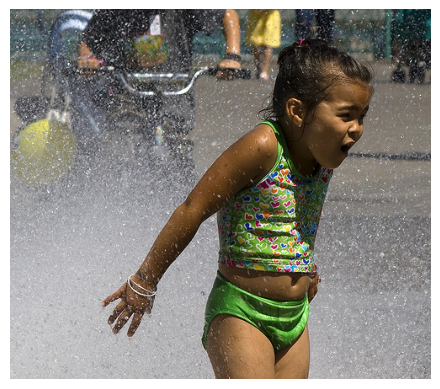

In [51]:
# 함수 호출 예시
generate_caption(r"C:\Users\user\대학\VScode_File\GG-Image_Caption\GG_ImageCaptionGenerator\flickr8k\Images\3765374230_cb1bbee0cb.jpg")

---------------------Actual---------------------
startseq little boy with bib on is watching the camera endseq
startseq small child in gray and orange winks their eye while holding silverware endseq
startseq tan-skinned child looking at the camera endseq
startseq young boy winks as he is eating endseq
startseq the little boy is holding spoon in his hand whilst winking one eye endseq
--------------------Predicted--------------------
startseq containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing containing


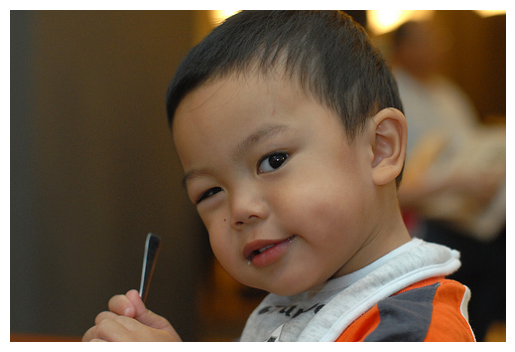

In [55]:
generate_caption(r"C:\Users\user\대학\VScode_File\GG-Image_Caption\GG_ImageCaptionGenerator\flickr8k\Images\3757598567_739b7da835.jpg")

## Test with Real Image

In [56]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [64]:
image_path = r"C:\Users\user\대학\VScode_File\GG-Image_Caption\GG_ImageCaptionGenerator\flickr8k\Images\3724487641_d2096f10e5.jpg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq landscape landscape landscape landscape landscape landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee'

---------------------Actual---------------------
startseq bunch of little boys in bathing trunks running endseq
startseq two wet boys in swim trunks run endseq
startseq two young boys competing in race endseq
startseq two young boys in bathing suits walk endseq
startseq young boys running along the pavement endseq
--------------------Predicted--------------------
startseq landscape landscape landscape landscape landscape landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee gurnee landscape gurnee landscape gurnee landscape gurnee


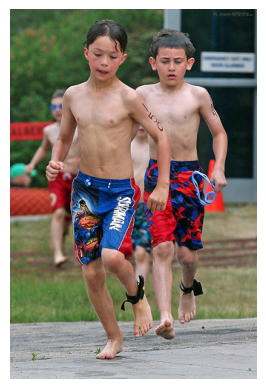

In [66]:

generate_caption(r"C:\Users\user\대학\VScode_File\GG-Image_Caption\GG_ImageCaptionGenerator\flickr8k\Images\3724487641_d2096f10e5.jpg")

---------------------Actual---------------------
startseq brown dog is running through brown field endseq
startseq brown dog is running through the field endseq
startseq brown dog with collar runs in the dead grass with his tongue hanging out to the side endseq
startseq brown dog with his tongue wagging as he runs through field endseq
startseq dog running in the grass endseq
--------------------Predicted--------------------
startseq slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices slices


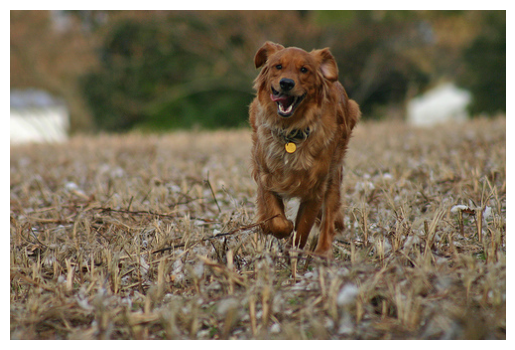

In [75]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    # 절대 경로인 경우와 상대 경로인 경우 모두 처리
    if os.path.isabs(image_name):
        img_path = image_name
        image_id = os.path.splitext(os.path.basename(image_name))[0]  # 파일 이름에서 image_id 추출
    else:
        image_id = image_name.split('.')[0]
        img_path = os.path.join(BASE_DIR, "Images", image_name)
    
    # 이미지 파일을 엽니다.
    try:
        image = Image.open(img_path)
    except FileNotFoundError:
        print(f"FileNotFoundError: The file {img_path} does not exist.")
        return
    
    # 캡션 출력
    captions = mapping.get(image_id, [])
    if not captions:
        print(f"No captions found for image ID '{image_id}'.")
        return
    
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    # 이미지에 대한 피처 확인 및 예측 수행
    if image_id in features:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('--------------------Predicted--------------------')
        print(y_pred)
    else:
        print(f"Warning: No features found for image ID '{image_id}'.")
    
    # 이미지 출력
    plt.imshow(image)
    plt.axis('off')  # 이미지 축 숨기기
    plt.show()

# 함수 호출 예시
generate_caption(r"C:\Users\user\대학\VScode_File\GG-Image_Caption\GG_ImageCaptionGenerator\flickr8k\Images\69189650_6687da7280.jpg")
